# Amazon SageMaker Semantic Segmentation Algorithm

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Data Preparation](#Data-Preparation)
  1. [Download data](#Download-data)
  2. [Setup Data](#Setup-data)
  3. [Upload to S3](#Upload-to-S3)
4. [Training](#Training)
5. [Hosting](#Hosting)
6. [Inference](#Inference)

## Introduction

Semantic Segmentation (SS) is the task of classifying every pixel in an image with a class from a known set of labels. In contrast, [image classification](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/imageclassification_caltech) generates only one label per image and [object detection](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco) generates a bounding box along with the label for each object in the image. The semantic segmentation output is usually represented as different pixel values in the image. Therefore, the output is an integer matrix (or a grayscale image) with the same shape as the input image. This output image is also called a segmentation mask. With the Amazon SageMaker Semantic Segmentation algorithm, not only can you train your models with your own dataset but also use our pre-trained models for lazy initialization.

This notebook is an end-to-end example introducing the Amazon SageMaker Semantic Segmentation algorithm. In this demo, we will demonstrate how to train and host a semantic segmentation model using the fully-convolutional network ([FCN](https://arxiv.org/abs/1605.06211)) algorithm using the [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/) for training. Amazon SageMaker Semantic Segmentation also provides the option of using Pyramid Scene Parsing Network([PSP](https://arxiv.org/abs/1612.01105)) and [Deeplab-v3](https://arxiv.org/abs/1706.05587) in addition to the FCN Network. Along the way, we will also demonstrate how to construct a training dataset in the format that the training job will consume. Finally, we will demonstrate how to host and validate the trained model.

## Setup

To train the Semantic Segmentation algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with, we need an AWS account role with SageMaker access. This role that is used to give SageMaker access to your data in S3 can automatically be obtained from the role used to start the notebook.

In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role
 
role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::900597767885:role/service-role/AmazonSageMaker-ExecutionRole-20200217T162463
CPU times: user 1.37 s, sys: 957 ms, total: 2.33 s
Wall time: 6.67 s


We also need the S3 bucket that is used to store training data and the trained model artifacts. In this notebook, we use the default bucket that comes with Sagemaker. However, you can also create a bucket and use that bucket instead.

In [2]:
bucket = sess.default_bucket()  
prefix = 'semantic-segmentation-demo'
print(bucket)

sagemaker-us-west-2-900597767885


Lastly, we need the Amazon SageMaker Semantic Segmentaion docker image, which is static and need not be changed.

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(sess.boto_region_name, 'semantic-segmentation', repo_version="latest")
print (training_image)

433757028032.dkr.ecr.us-west-2.amazonaws.com/semantic-segmentation:latest


## Data Preparation
[Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) is a popular computer vision dataset which is used for annual semantic segmentation challenges from 2005 to 2012. The dataset has 1464 training and 1449 validation images with 21 classes. Examples of the segmentation dataset can be seen in the [Pascal VOC Dataset page](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/index.html). The classes are as follows:

| Label Id |     Class     |
|:--------:|:-------------:|
|     0    |   Background  |
|     1    |   Aeroplane   |
|     2    |    Bicycle    |
|     3    |      Bird     |
|     4    |      Boat     |
|    5     |     Bottle    |
|     6    |      Bus      |
|     7    |      Car      |
|     8    |      Cat      |
|     9    |     Chair     |
|    10    |      Cow      |
|    11    |  Dining Table |
|    12    |      Dog      |
|    13    |     Horse     |
|    14    |   Motorbike   |
|    15    |     Person    |
|    16    |  Potted Plant |
|    17    |     Sheep     |
|    18    |      Sofa     |
|    19    |     Train     |
|    20    |  TV / Monitor |
|    255   | Hole / Ignore |

In this notebook, we will use the data sets from 2012. While using the Pascal VOC dataset, please be aware of the  usage rights:
"The VOC data includes images obtained from the "flickr" website. Use of these images must respect the corresponding terms of use: 
* "flickr" terms of use (https://www.flickr.com/help/terms)"

### Download data
Let us download the Pascal VOC datasets from VOC 2012.

If this notebook was run before, you may have downloaded some data and set them up. If you have done this section properly, do not run the cell below as it will download the data all over again. If you have downloaded and want to re-download and reprocess the data, run the cell below to clean the previous download.

If you have already downloaded and setup the data, you do not need to run the following cells in this section. You can instead use the previous S3 bucket. If not clean up directories created from the previous run.

In [4]:
# !rm -rf train
# !rm -rf train_annotation
# !rm -rf validation
# !rm -rf validation_annotation
# !rm -rf VOCdevkit
# !rm test.jpg
# !rm test_reshaped.jpg
# !rm train_label_map.json

In [5]:
%%time

# Download the dataset
!wget -P /tmp http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar    
# # Extract the data.
!tar -xf /tmp/VOCtrainval_11-May-2012.tar && rm /tmp/VOCtrainval_11-May-2012.tar

--2020-04-16 21:51:05--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘/tmp/VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  8.69MB/s    in 3m 48s  

2020-04-16 21:54:53 (8.37 MB/s) - ‘/tmp/VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]

CPU times: user 2.42 s, sys: 686 ms, total: 3.1 s
Wall time: 3min 50s


### Setup data
Move the images into appropriate directory structure as described in the [documentation](link-to-documentation). This is quite simply, moving the training images to `train` directory and so on. Fortunately, the dataset's annotations are already named in sync with the image names, satisfying one requirement of the Amazon SageMaker Semantic Segmentation algorithm.

In [6]:
import os
import shutil

# Create directory structure mimicing the s3 bucket where data is to be dumped.
VOC2012 = 'VOCdevkit/VOC2012'
os.makedirs('train', exist_ok=True)
os.makedirs('validation', exist_ok=True)
os.makedirs('train_annotation', exist_ok=True)
os.makedirs('validation_annotation', exist_ok=True)

# Create a list of all training images.
filename = VOC2012+'/ImageSets/Segmentation/train.txt'
with open(filename) as f:
    train_list = f.read().splitlines() 

# Create a list of all validation images.
filename = VOC2012+'/ImageSets/Segmentation/val.txt'
with open(filename) as f:
    val_list = f.read().splitlines() 

# Move the jpg images in training list to train directory and png images to train_annotation directory.
for i in train_list:
    shutil.copy2(VOC2012+'/JPEGImages/'+i+'.jpg', 'train/')
    shutil.copy2(VOC2012+'/SegmentationClass/'+i+'.png','train_annotation/' )

# Move the jpg images in validation list to validation directory and png images to validation_annotation directory.
for i in val_list:
    shutil.copy2(VOC2012+'/JPEGImages/'+i+'.jpg', 'validation/')
    shutil.copy2(VOC2012+'/SegmentationClass/'+i+'.png','validation_annotation/' )

Let us check if the move was completed correctly. If it was done correctly, the number of jpeg images in `train` and png images in `train_annotation` must be the same, and so in validation as well.

In [7]:
import glob
num_training_samples=len(glob.glob1('train',"*.jpg"))

print ( ' Num Train Images = ' + str(num_training_samples))
assert num_training_samples == len(glob.glob1('train_annotation',"*.png"))

print ( ' Num Validation Images = ' + str(len(glob.glob1('validation',"*.jpg"))))
assert len(glob.glob1('validation',"*.jpg")) == len(glob.glob1('validation_annotation',"*.png"))

 Num Train Images = 1464
 Num Validation Images = 1449


Let us now move our prepared datset to the S3 bucket that we decided to use in this notebook earlier. Notice the following directory structure that is used.

```bash
root 
|-train/
|-train_annotation/
|-validation/
|-validation_annotation/

```
Notice also that all the images in the `_annotation` directory are all indexed PNG files. This implies that the metadata (color mapping modes) of the files contain information on how to map the indices to colors and vice versa. Having an indexed PNG is an advantage as the images will be rendered by image viewers as color images, but the image themsevels only contain integers. The integers are also within `[0, 1 ... c-1, 255]`  for a `c` class segmentation problem, with `255` as 'hole' or 'ignore' class. We allow any mode that is a [recognized standard](https://pillow.readthedocs.io/en/3.0.x/handbook/concepts.html#concept-modes) as long as they are read as integers.

While we recommend the format with default color mapping modes such as PASCAL, we also allow the customers to specify their own label maps. Refer to the [documentation](Permalink-to-label-map-documentation-section) for more details. The label map for the PASCAL VOC dataset, is the default (which we use incase no label maps are provided): 
```json
{
    "scale": 1
}```
This essentially tells us to simply use the images as read as integers as labels directly. Since we are using PASCAL dataset, let us create (recreate the default just for demonstration) label map for training channel and let the algorithm use the default (which is exactly the same for the validation channel). If `label_map` is used, please pass it to the label_map channel.


In [8]:
import json
label_map = { "scale": 1 }
with open('train_label_map.json', 'w') as lm_fname:
    json.dump(label_map, lm_fname)

In [9]:
# Create channel names for the s3 bucket.
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'
# label_map_channel = prefix + '/label_map'

### Upload to S3
Let us now upload our dataset including our label map.

In [10]:
%%time
# upload the appropraite directory up to s3 respectively for all directories.
sess.upload_data(path='train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)
# sess.upload_data(path='train_label_map.json', bucket=bucket, key_prefix=label_map_channel)

CPU times: user 28 s, sys: 1.94 s, total: 29.9 s
Wall time: 6min 12s


Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job. Let us use another channel in the same S3 bucket for this purpose.

In [11]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
print(s3_output_location)

s3://sagemaker-us-west-2-900597767885/semantic-segmentation-demo/output


## Training
Now that we are done with all the setup that is needed, we are ready to train our segmentation algorithm. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job. Let us name our training job as `ss-notebook-demo`. Let us also use a nice-and-fast GPU instance (`ml.p3.2xlarge`) to train.

In [12]:
# Create the sagemaker estimator object.
ss_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count = 1, 
                                         train_instance_type = 'ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         output_path = s3_output_location,
                                         base_job_name = 'ss-notebook-demo',
                                         sagemaker_session = sess)

The semantic segmentation algorithm at its core has two compoenents.

- An encoder or backbone network,
- A decoder or algorithm network. 

The encoder or backbone network is typically a regular convolutional neural network that may or maynot have had their layers pre-trained on an alternate task such as the [classification task of ImageNet images](http://www.image-net.org/). The Amazon SageMaker Semantic Segmentation algorithm comes with two choices of pre-trained or to be trained-from-scratch backbone networks ([ResNets](https://arxiv.org/abs/1512.03385) 50 or 101). 

The decoder is a network that picks up the outputs of one or many layers from the backbone and reconstructs the segmentation mask from it. Amazon SageMaker Semantic Segmentation algorithm comes with a choice of the [Fully-convolutional network (FCN)](https://arxiv.org/abs/1605.06211) or the [Pyramid scene parsing (PSP) network](https://arxiv.org/abs/1612.01105).

The algorithm also has ample options for hyperparameters that help configure the training job. The next step in our training, is to setup these networks and hyperparameters along with data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Semantic Segmentation [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/semantic-segmentation.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only `10` epochs. Based on our tests, train the model for `30` epochs with similar settings should give us 'reasonable' segmentation results on the Pascal VOC data. For the most part, we will stick to using the simplest of settings. For more information on the hyperparameters of this algorithm, refer to the [documentation](perma-link-to-hyperparameter-section-in-documentation).

In [13]:
# Setup hyperparameters 
ss_model.set_hyperparameters(backbone='resnet-50', # This is the encoder. Other option is resnet-50
                             algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
                             use_pretrained_model='True', # Use the pre-trained model.
                             crop_size=240, # Size of image random crop.                             
                             num_classes=21, # Pascal has 21 classes. This is a mandatory parameter.
                             epochs=10, # Number of epochs to run.
                             learning_rate=0.0001,                             
                             optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                             lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
                             mini_batch_size=16, # Setup some mini batch size.
                             validation_mini_batch_size=16,
                             early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                             early_stopping_patience=2, # Tolerate these many epochs if the mIoU doens't increase.
                             early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
                             num_training_samples=num_training_samples) # This is a mandatory parameter, 1464 in this case.

Now that the hyperparameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm uses to train.

In [14]:
# Create full bucket names
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

distribution = 'FullyReplicated'
# Create sagemaker s3_input objects
train_data = sagemaker.session.s3_input(s3_train_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 
                 'validation': validation_data,
                 'train_annotation': train_annotation, 
                 'validation_annotation':validation_annotation}

We have our `Estimator` object, we have set the hyperparameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the `Estimator` classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take time, depending on the size of the data and the availability of the type of instances. Therefore it might be a few minutes before we start getting data logs for our training jobs. The data logs will also print out training loss on the training data, which is the pixel-wise cross-entropy loss as described in the algorithm papers. The data logs will also print out pixel-wise label accuracy and mean intersection-over-union (mIoU) on the validation data after a run of the dataset once or one epoch. These metrics measure the quality of the model under training.

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [15]:
ss_model.fit(inputs=data_channels, logs=True)

2020-04-16 22:01:09 Starting - Starting the training job......
2020-04-16 22:01:39 Starting - Launching requested ML instances......
2020-04-16 22:03:09 Starting - Preparing the instances for training.........
2020-04-16 22:04:15 Downloading - Downloading input data...
2020-04-16 22:05:06 Training - Downloading the training image.......Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[04/16/2020 22:06:15 INFO 140103637968704] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'_aux_weight': u'0.5', u'_hybrid': u'False', u'_augmentation_type': u'default', u'lr_scheduler': u'poly', u'early_stoppi

[04/16/2020 22:07:41 INFO 140103637968704] #progress_notice. epoch: 1, iterations: 20 speed: 56.1376101586 samples/sec learning_rate: 0.000089
[04/16/2020 22:07:47 INFO 140103637968704] #progress_notice. epoch: 1, iterations: 40 speed: 56.5558767363 samples/sec learning_rate: 0.000087
[04/16/2020 22:07:53 INFO 140103637968704] #progress_notice. epoch: 1, iterations: 60 speed: 56.0030175881 samples/sec learning_rate: 0.000085
[04/16/2020 22:07:59 INFO 140103637968704] #progress_notice. epoch: 1, iterations: 80 speed: 56.4868031093 samples/sec learning_rate: 0.000083
[04/16/2020 22:08:02 INFO 140103637968704] #quality_metric. host: algo-1, epoch: 1, train loss: 1.0209123641252518 .
[04/16/2020 22:08:02 INFO 140103637968704] #throughput_metric. host: algo-1, epoch: 1, train throughput: 55.104122459 samples/sec.
[04/16/2020 22:08:12 INFO 140103637968704] #progress_notice. epoch: 1, iterations: 20 speed: 38.4252338562 samples/sec
[04/16/2020 22:08:21 INFO 140103637968704] #progress_notice. 

[04/16/2020 22:11:08 INFO 140103637968704] #progress_notice. epoch: 4, iterations: 20 speed: 56.2413482732 samples/sec learning_rate: 0.000061
[04/16/2020 22:11:14 INFO 140103637968704] #progress_notice. epoch: 4, iterations: 40 speed: 56.3594772614 samples/sec learning_rate: 0.000059
[04/16/2020 22:11:20 INFO 140103637968704] #progress_notice. epoch: 4, iterations: 60 speed: 56.1995246701 samples/sec learning_rate: 0.000057
[04/16/2020 22:11:26 INFO 140103637968704] #progress_notice. epoch: 4, iterations: 80 speed: 56.6052980959 samples/sec learning_rate: 0.000054
[04/16/2020 22:11:29 INFO 140103637968704] #quality_metric. host: algo-1, epoch: 4, train loss: 0.7346916228205294 .
[04/16/2020 22:11:29 INFO 140103637968704] #throughput_metric. host: algo-1, epoch: 4, train throughput: 54.916822484 samples/sec.
[04/16/2020 22:11:39 INFO 140103637968704] #progress_notice. epoch: 4, iterations: 20 speed: 37.9313279298 samples/sec
[04/16/2020 22:11:47 INFO 140103637968704] #progress_notice. 

[04/16/2020 22:14:35 INFO 140103637968704] #progress_notice. epoch: 7, iterations: 20 speed: 56.4316086266 samples/sec learning_rate: 0.000031
[04/16/2020 22:14:40 INFO 140103637968704] #progress_notice. epoch: 7, iterations: 40 speed: 56.3572527495 samples/sec learning_rate: 0.000029
[04/16/2020 22:14:46 INFO 140103637968704] #progress_notice. epoch: 7, iterations: 60 speed: 56.1045228819 samples/sec learning_rate: 0.000027
[04/16/2020 22:14:52 INFO 140103637968704] #progress_notice. epoch: 7, iterations: 80 speed: 56.4121121234 samples/sec learning_rate: 0.000024
[04/16/2020 22:14:55 INFO 140103637968704] #quality_metric. host: algo-1, epoch: 7, train loss: 0.6255758680079294 .
[04/16/2020 22:14:55 INFO 140103637968704] #throughput_metric. host: algo-1, epoch: 7, train throughput: 54.7471366805 samples/sec.
[04/16/2020 22:15:06 INFO 140103637968704] #progress_notice. epoch: 7, iterations: 20 speed: 36.2268700934 samples/sec
[04/16/2020 22:15:14 INFO 140103637968704] #progress_notice.

#metrics {"Metrics": {"epochs": {"count": 1, "max": 10, "sum": 10.0, "min": 10}, "totaltime": {"count": 1, "max": 699597.592830658, "sum": 699597.592830658, "min": 699597.592830658}, "setuptime": {"count": 1, "max": 18.959999084472656, "sum": 18.959999084472656, "min": 18.959999084472656}}, "EndTime": 1587075475.046817, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/Semantic Segmentation"}, "StartTime": 1587074776.913963}


2020-04-16 22:17:58 Uploading - Uploading generated training model
2020-04-16 22:18:40 Completed - Training job completed
Training seconds: 865
Billable seconds: 865


# Hosting
Once the training is done, we can deploy the trained model as an Amazon SageMaker hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same instance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any sagemaker supported instance we want to host the model. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.c5.xlarge`. The endpoint deployment can be accomplished as follows:

In [16]:
ss_predictor = ss_model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

---------------!

## Inference
Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. To do this, let us download an image from [PEXELS](https://www.pexels.com/) which the algorithm has so-far not seen. 

In [41]:
!wget -O test.jpg https://upload.wikimedia.org/wikipedia/commons/b/b4/R1200RT_in_Hongkong.jpg
filename = 'test.jpg'

--2020-04-16 22:36:16--  https://upload.wikimedia.org/wikipedia/commons/b/b4/R1200RT_in_Hongkong.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1047212 (1023K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   1023K  --.-KB/s    in 0.1s    

2020-04-16 22:36:16 (7.52 MB/s) - ‘test.jpg’ saved [1047212/1047212]



Let us convert the image to bytearray before we supply it to our endpoint.

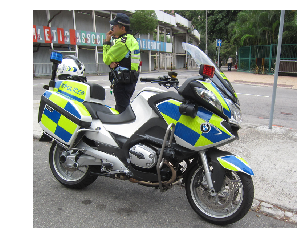

In [42]:
import matplotlib.pyplot as plt

import PIL

# resize image size for inference
im = PIL.Image.open(filename)
im.thumbnail([800,600],PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")


%matplotlib inline
plt.imshow(im)
plt.axis('off')
with open(filename, 'rb') as image:
    img = image.read()
    img = bytearray(img)

The endpoint accepts images in formats similar to the ones found images in the training dataset. It accepts the `image/jpeg` `content_type`. The `accept` parameter takes on two values: `image/png` and `application/x-protobuf`. For customers who want an indexed-PNG segmentation mask such as the ones that were used during training, can use the `image/png` accept type as shown in the example below. Using this endpoint will return a image bytearray.

In [43]:
%%time 
ss_predictor.content_type = 'image/jpeg'
ss_predictor.accept = 'image/png'
return_img = ss_predictor.predict(img)

CPU times: user 16.2 ms, sys: 0 ns, total: 16.2 ms
Wall time: 9.4 s


Let us display the segmentation mask.

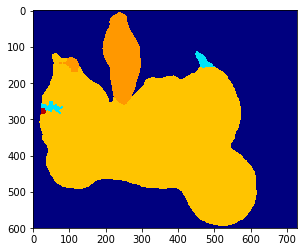

In [44]:
from PIL import Image
import numpy as np
import io

num_classes = 21
mask = np.array(Image.open(io.BytesIO(return_img)))
plt.imshow(mask, vmin=0, vmax=num_classes-1, cmap='jet')
plt.show()

The second `accept` type allows us to request all the class probabilities for each pixels. Let us use our endpoint to try to predict the probabilites of segments within this image. Since the image is `jpeg`, we use the appropriate `content_type` to run the prediction job. The endpoint returns a file that we can simply load and peek into.

In [ ]:
%%time
# resize image size for inference
im = PIL.Image.open(filename)
im.thumbnail([800,600],PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")
with open(filename, 'rb') as image:
    img = image.read()
    img = bytearray(img)
    
ss_predictor.content_type = 'image/jpeg'
ss_predictor.accept = 'application/x-protobuf'
results = ss_predictor.predict(img)

What we receive back is a recordio-protobuf of probablities sent as a binary. It takes a little bit of effort to convert into a readable array. Let us convert them to numpy format. We can make use of `mxnet` that has the capability to read recordio-protobuf formats. Using this, we can convert the outcoming bytearray into numpy array.

In [38]:
from sagemaker.amazon.record_pb2 import Record
import mxnet as mx

results_file = 'results.rec'
with open(results_file, 'wb') as f:
    f.write(results)

rec = Record()
recordio = mx.recordio.MXRecordIO(results_file, 'r')
protobuf = rec.ParseFromString(recordio.read())

The protobuf array has two parts to it. The first part contains the shape of the output and the second contains the values of probabilites. Using the output shape, we can transform the probabilities into the shape of the image, so that we get a map of values. There typically is a singleton dimension since we are only inferring on one image. We can also remove that using the `squeeze` method.

In [39]:
values = list(rec.features["target"].float32_tensor.values)
shape = list(rec.features["shape"].int32_tensor.values)
shape = np.squeeze(shape)
mask = np.reshape(np.array(values), shape)
mask = np.squeeze(mask, axis=0)

So as to plot the segmentation mask from the list of probabilities, let us get the indices of the most probable class for each pixel. We can do this by measuring the `argmax` across the classes axis of the probability data. To plot the probabilites as image, we can use the `numpy.argmax` method to find out which probabilities are the largest and plot only those as a segmentaiton mask.

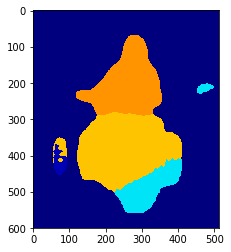

In [40]:
pred_map = np.argmax(mask, axis=0)
num_classes = 21
plt.imshow(pred_map, vmin=0, vmax=num_classes-1, cmap='jet')
plt.show()

## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [ ]:
sagemaker.Session().delete_endpoint(ss_predictor.endpoint)